# eboss Y1v5_10_7 analyses
In this notebook, we demonstrate the steps taken for our analysis      
Contents<a id="top"></a>:
1. <a href="#s1">w plate_SSR</a>             
    1.1 simple clustering for 21, 22, and 23 chunks <a href="#s1.1"> link </a>
2. <a href="#s2">wo plate_SSR</a>                
    2.1 n(z) for 21, 22, and 23 chunks vs. combined <a href="#s2.1"> link </a>                      
    2.2 clustering of  21, 22, 23 vs 21-22 combined <a href="#s2.2"> link </a>                    
    2.3 looking at $\delta$ vs. nstar <a href="#s2.3"> link </a>                                   
    2.4 different zbin <a href="#s2.4"> link </a>                                   
    2.5 NN for RBS <a href="#s2.5"> link </a>  
    2.6 correlation between ngal and RBS <a href="#s2.6"> link</a>

In [2]:
# tools
import sys
sys.path.append('/Users/mthecosmologist/Dropbox/github/DESILSS')

In [3]:
import os
import fitsio as ft
import healpy as hp
import numpy as np
from ebosstools import makeNz, computePk, SYSweight

In [4]:
from tools import camb_pk, rsd, growthrate
from tools import D as growthfunc

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', size=25, family='sans-serif')
plt.rc('axes.spines', right=False, top=False)
plt.rc('figure', figsize=(12,8))

In [5]:
# theory 
zmid = np.sum([0.75,1.1])/2
print(zmid)
# zmid = 0.0
theory_pk = camb_pk(omc=0.31)
kt, plkt = theory_pk.get_plk(zmid, bias=1.5)

0.925


s8 : [ 0.53449559]


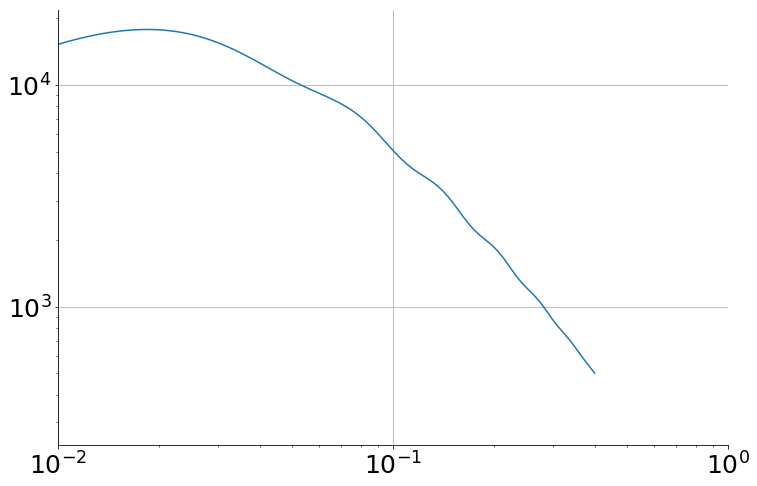

In [6]:
plt.plot(kt, plkt[:,0])
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01, 1.)
plt.grid()

## w/ plate_SSR <a id="s1"></a>
### simple clustering for 21,22 and 23 chunks
calculating n(z) (<a href="#top">top</a>)

Text(0,0.5,'n(z) [10$^{4}(h/Mpc)^{3}$]')

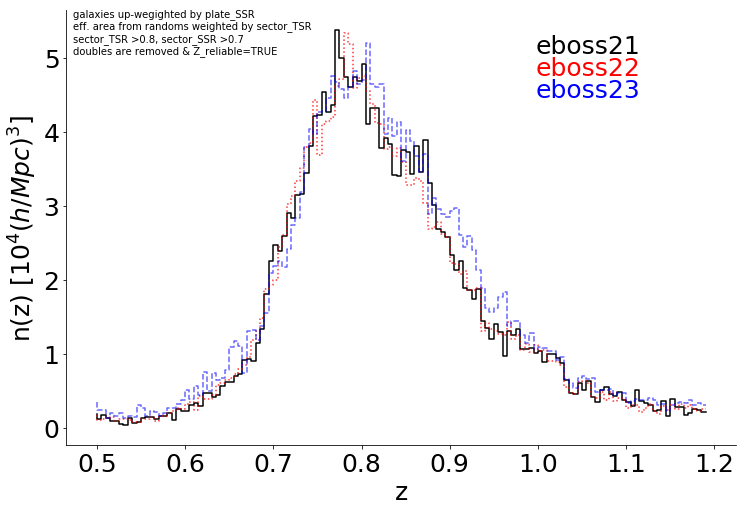

In [6]:
path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/nofz/'
ax = plt.subplot(111)
c  = ['k','r','b']
lt = ['-',':','--']
for i in range(3):
    z, nz = np.loadtxt(path2nofz+'nofz_eboss2'+str(i+1)+'.dat').T
    ax.step(z, 1e4*nz, linestyle=lt[i], color=c[i], alpha=1.0-0.2*i)
    ax.text(0.7,0.90-i*0.05, 'eboss2'+str(i+1), transform=ax.transAxes, color=c[i])
    if i ==0:ax.text(0.01, 0.9, 'galaxies up-wegighted by plate_SSR\n'
                                +'eff. area from randoms weighted by sector_TSR\n'
                                 +'sector_TSR >0.8, sector_SSR >0.7\n'
                                 +'doubles are removed & Z_reliable=TRUE',
                    transform=ax.transAxes, fontsize=10)
ax.set_xlabel('z')
ax.set_ylabel(r'n(z) [10$^{4}(h/Mpc)^{3}$]')

Clustering results with the above n(z) <a id="s1.1"></a> <a href="#top">top</a>

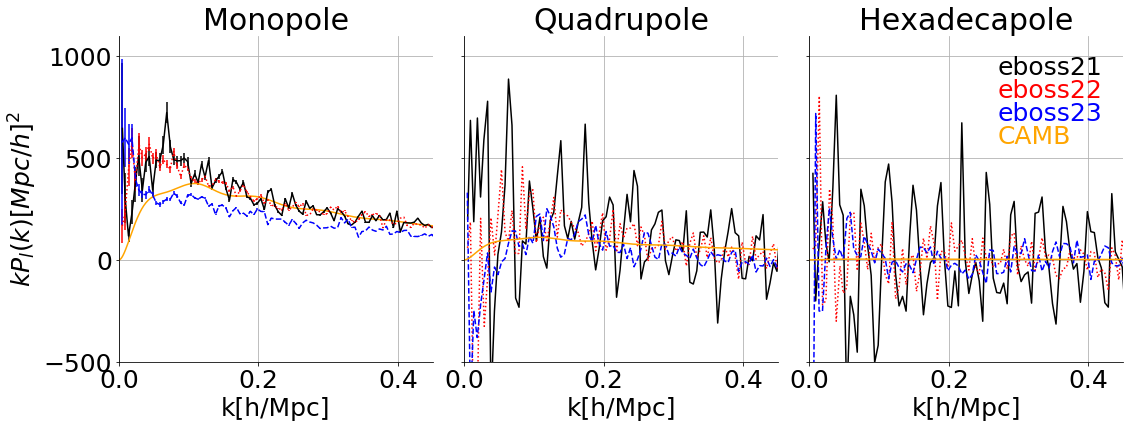

In [7]:
f,ax = plt.subplots(ncols=3, sharey=True, figsize=(18,6))
plt.subplots_adjust(wspace=0.1)
c  = ['','k','r','b']
lt = ['','-',':','--']
for i in range(1,4):
    # reading pks
    path2pks ='/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpks-v05/'
    pkou = np.load(path2pks+'kpkeboss2'+str(i)+'Y1v5_10_7v05.npy').item()
    # pk
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p4 = pkou['poles_data']['power_4'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    #
    ax[0].errorbar(k, k*p0, k*p0e, color=c[i], ls=lt[i])
    ax[1].plot(k, k*p2, color=c[i], ls=lt[i])
    ax[2].plot(k, k*p4, color=c[i], ls=lt[i])
    ax[2].text(0.6,0.95-i*0.07, 'eboss2'+str(i), transform=ax[2].transAxes, color=c[i])
    if i==1:ax[2].text(0.6,0.95-4*0.07, 'CAMB', transform=ax[2].transAxes, color='orange')


ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
ttl = ['Monopole','Quadrupole', 'Hexadecapole']
for i,a in enumerate(ax):
    a.plot(kt, kt*plkt[:,i], color='orange') # theory
    a.set_title(ttl[i])
    a.set_xlim(0.0,0.45)
    a.set_xlabel(r'k[h/Mpc]')
#     a.set_xscale('log')
#     a.set_yscale('log')
    a.set_ylim(-500, 1100)
    a.grid()

## w/o plate_SSR <a id="s2"></a>
a new version of scripts, which works with a dictionary holding parameters (<a href="#top"> top</a>)

In [7]:
path2cats = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
r  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.rands.fits'

#path4nofz = path2cats+'nofz'
#path4nofz = path2cats+'nofz_woSSR'
#path4nofz = path2cats+'nofz_21and22'
analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              path4nofz=path2cats+analysis,
              nofzname='nofz_ebossY1v5_10_7',
              zlim=(0.6,1.1),
              nmesh=256,
              kpkname='kpk_ebossY1v5_10_7',
              path4kpks=path2cats+analysis
             )

In [5]:
# 21, 22, 23 separate
allsep = makeNz(['1','2','3'], **kwargs)
allsep.run(save=True, combined=False, **kwargs)
print(allsep.log)

# pipeline to get n(z) for catalogs ['1', '2', '3']
# going to make n(z) while combined:False
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# area 145.8878deg2 fsky 0.0035364167454488156
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# area 319.43395deg2 fsky 0.0077432901849562455
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# area 165.56625deg2 fsky 0.004013435386517344
# nofz_ebossY1v5_10_7_combinedF is written under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR



### Combining 22 and 23 chunks

In [6]:
combd = makeNz(['1','2'], **kwargs)
combd.run(save=True, combined=True,**kwargs)
print(combd.log)

# pipeline to get n(z) for catalogs ['1', '2']
# going to make n(z) while combined:True
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# area 465.32185deg2 fsky 0.011279709354471189
# nofz_ebossY1v5_10_7_combinedT is written under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR



Plot of n(z)<a id="s2.1"></a> <a href="#top">top</a>

Text(0,0.5,'n(z) [10$^{4}(h/Mpc)^{3}$]')

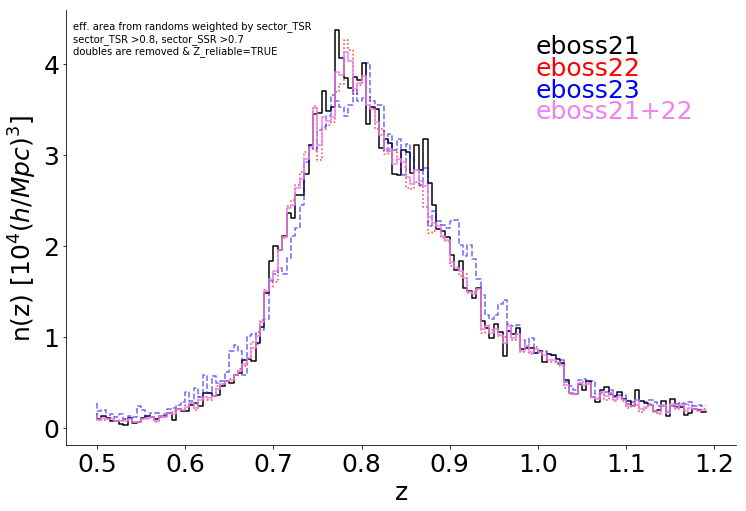

In [8]:
nzall = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/nofz_ebossY1v5_10_7_combinedF.npy').item()
nzcomb = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/nofz_ebossY1v5_10_7_combinedT.npy').item()
ax = plt.subplot(111)
c  = ['k','r','b']
lt = ['-',':','--']
for i in range(len(nzall['znz'][0])):
    z, nz = nzall['znz'][0][i], nzall['znz'][1][i]
    ax.step(z, 1e4*nz, linestyle=lt[i], color=c[i], alpha=1.0-0.2*i)
    ax.text(0.7,0.90-i*0.05, 'eboss2'+str(i+1), transform=ax.transAxes, color=c[i])
    if i ==0:ax.text(0.01, 0.9, 'eff. area from randoms weighted by sector_TSR\n'
                                 +'sector_TSR >0.8, sector_SSR >0.7\n'
                                 +'doubles are removed & Z_reliable=TRUE',
                    transform=ax.transAxes, fontsize=10)

z, nz = nzcomb['znz'][0], nzcomb['znz'][1]
ax.step(z, 1e4*nz, linestyle='-', color='violet', alpha=1.0)
ax.text(0.7, 0.9-.15, 'eboss21+22', transform=ax.transAxes, color='violet')
ax.set_xlabel('z')
ax.set_ylabel(r'n(z) [10$^{4}(h/Mpc)^{3}$]')

In [7]:
path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'\
            +'woSSR/nofz_ebossY1v5_10_7_combinedF.npy'
pksep = computePk(['1','2','3'], **kwargs)
pksep.run(save=True, combined=False, path2nofz=path2nofz, **kwargs)
print(pksep.log)

/Users/mthecosmologist/anaconda3/envs/nbodykit/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:160: FutureWarning: This init signature is deprecated; see the Cosmology docstring for new signature
  "docstring for new signature"), FutureWarning)


# pipeline to get P(k) for catalogs ['1', '2', '3']
# going to make P(k) while combined:False
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.6 < z < 1.1 with nmesh of 256 
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.6 < z < 1.1 with nmesh of 256 
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.6 < z < 1.1 with nmesh of 256 
# kpk_ebossY1v5_10_7_combinedF is written under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR



In [8]:
path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'\
            +'woSSR/nofz_ebossY1v5_10_7_combinedT.npy'
pkcomb = computePk(['1','2'], **kwargs)
pkcomb.run(save=True, combined=True, path2nofz=path2nofz, **kwargs)
print(pkcomb.log)

/Users/mthecosmologist/anaconda3/envs/nbodykit/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:160: FutureWarning: This init signature is deprecated; see the Cosmology docstring for new signature
  "docstring for new signature"), FutureWarning)


# pipeline to get P(k) for catalogs ['1', '2']
# going to make P(k) while combined:True
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.6 < z < 1.1 with nmesh of 256 
# kpk_ebossY1v5_10_7_combinedT is written under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR



In [9]:
%ls /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR

kpk_ebossY1v5_10_7_combinedF.npy
kpk_ebossY1v5_10_7_combinedT.npy
kpk_ebossY1v5_10_7wsysfit_combinedT.npy
nofz_ebossY1v5_10_7_combinedF.npy
nofz_ebossY1v5_10_7_combinedT.npy


Plot of pk measurments <a id="s2.2"></a> <a href="#top"> top</a>

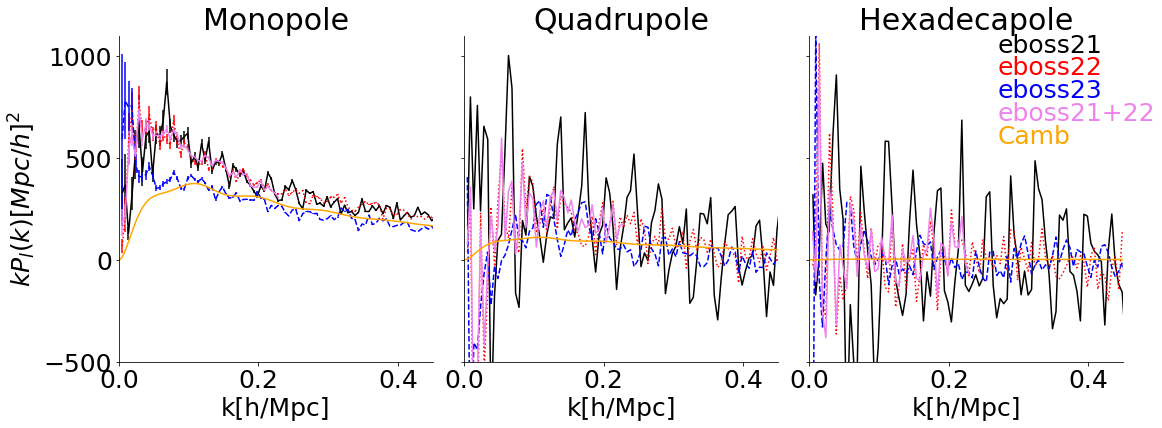

In [10]:
def helper(pkou):
    # break down to k, p0,...
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p4 = pkou['poles_data']['power_4'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    return k, p0, p2, p4, p0e

def addcurve(k, p0, p2, p4, p0e, ax, c, lt, label, i):
    # add curves to plots
    ax[0].errorbar(k, k*p0, k*p0e, color=c, ls=lt)
    ax[1].plot(k, k*p2, color=c, ls=lt)
    ax[2].plot(k, k*p4, color=c, ls=lt)
    ax[2].text(0.6,0.95-i*0.07, label, transform=ax[2].transAxes, color=c)

    
pkall = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7_combinedF.npy').item()
pkcomb = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7_combinedT.npy').item()
#
f,ax = plt.subplots(ncols=3, sharey=True, figsize=(18,6))
plt.subplots_adjust(wspace=0.1)
#
c  = ['k','r','b']
lt = ['-',':','--']
ttl = ['Monopole','Quadrupole', 'Hexadecapole']
#
for i in range(3):
    k, p0, p2, p4, p0e = helper(pkall['kpk'][i])
    addcurve(k, p0, p2, p4, p0e, ax, c[i], lt[i], 'eboss2'+str(i+1), i)
#
k, p0, p2, p4, p0e = helper(pkcomb['kpk'])
addcurve(k, p0, p2, p4, p0e, ax, 'violet', '-', 'eboss21+22', 3)
addcurve(kt, plkt[:,0], plkt[:,1], plkt[:,2], 0.0, ax, 'orange', '-', 'Camb', 4)
#
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
for i,a in enumerate(ax):
    a.set_title(ttl[i])
    a.set_xlim(0.0,0.45)
    a.set_xlabel(r'k[h/Mpc]')
    a.set_ylim(-500, 1100)

### $\delta$ vs. systematics <a id="s2.3"></a> <a href="#top">top</a>

look at `kwargs`

In [37]:
kwargs.keys(), kwargs['rancolnames']

(dict_keys(['ran_per_sqdeg', 'cosmo_params', 'tsrmin', 'ssrmin', 'galcolnames', 'rancolnames', 'zbins', 'path4nofz', 'nofzname', 'zlim', 'sysweight', 'nmesh', 'kpkname', 'path4kpks']),
 ['ra', 'dec', 'sector_ssr', 'sector_tsr'])

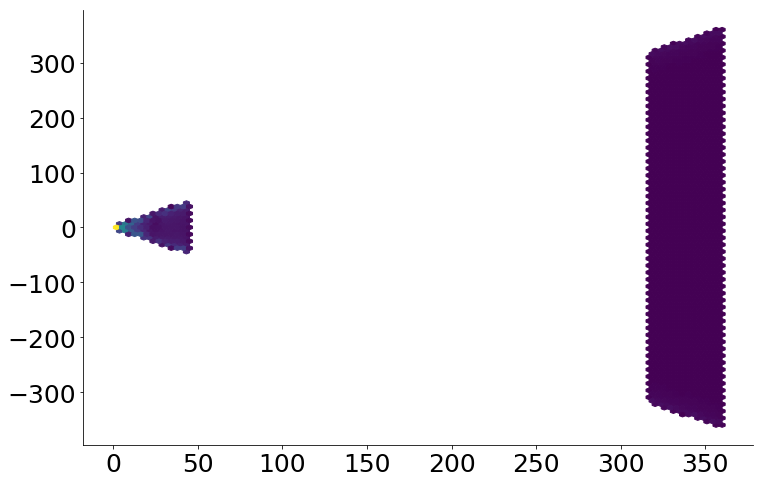

In [38]:
ran = []
for i in [1, 2]:
    ran.append(ft.read(r(str(i)), lower=True, columns=kwargs['rancolnames']))
ran = np.concatenate(ran)
ax = plt.subplot(111)
ax.hexbin(ran['ra'], ran['ra']*np.sin(ran['dec']), C=ran['sector_tsr'], reduce_C_function=np.sum)

In [39]:
ranmask = (ran['sector_tsr'] > kwargs['tsrmin']) & (ran['sector_ssr'] > kwargs['ssrmin'])
ran = ran[ranmask]

In [40]:
from syslss import hpixsum

In [41]:
ranmap = hpixsum(256, ran['ra'], ran['dec'], value=ran['sector_tsr'])

In [42]:
import healpy as hp

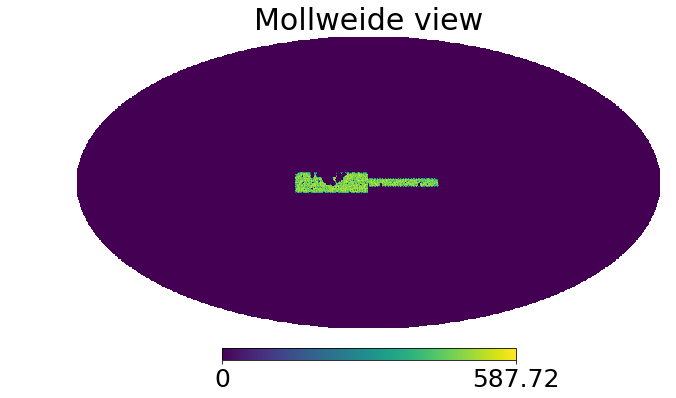

In [43]:
hp.mollview(ranmap)

In [26]:
ft.write('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/sector_tsr_ssr_mask_p8_p7.fits', ranmap)

In [44]:
ranmap = ft.read('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/sector_tsr_ssr_mask_p8_p7.fits')

In [46]:
irs = ft.read('/Volumes/Mehdi_Passport/NERSC_archive/other_files/dr3.1/heal_rbs_256.fits')

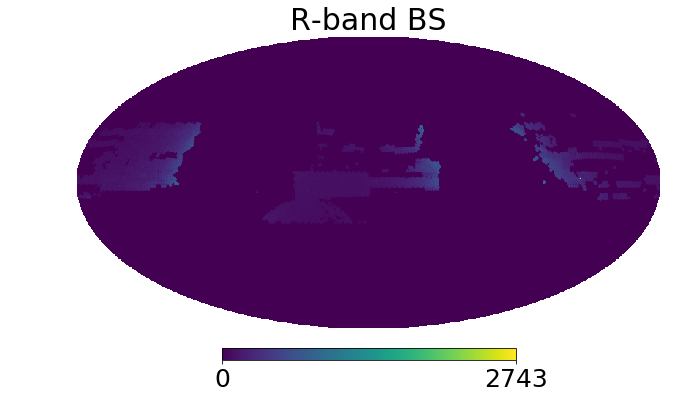

In [47]:
hp.mollview(irs, title='R-band BS')

In [48]:
from syslss import ngalsys

In [49]:
class cat(object):
    def __init__(self, catname):
        df = catname #ft.read(catname, lower=True)
        self.RA = df['ra']
        self.DEC = df['dec']
        self.Weight = np.ones(df['ra'].size)
class systematic(object):
    def __init__(self, sysname, mask):
        df = sysname #ft.read(sysname, lower=True)
        self.HPIX = np.argwhere(~np.logical_not(mask)).flatten()
        self.SIGNAL = df[~np.logical_not(mask)]

In [50]:
gal = []
for i in [1, 2]:
    gal.append(ft.read(g(str(i)), lower=True, columns=kwargs['galcolnames']))
gal = np.concatenate(gal)

In [51]:
galmask = (gal['sector_tsr'] > kwargs['tsrmin']) & (gal['sector_ssr'] > kwargs['ssrmin'])
galmask &= (gal['z'] > kwargs['zlim'][0]) & (gal['z'] < kwargs['zlim'][1])
galmask &= (gal['z_reliable']) & (~gal['isdupl'])
gal = gal[galmask]

In [52]:
galm = cat(gal)
irs256 = systematic(irs, ranmap)

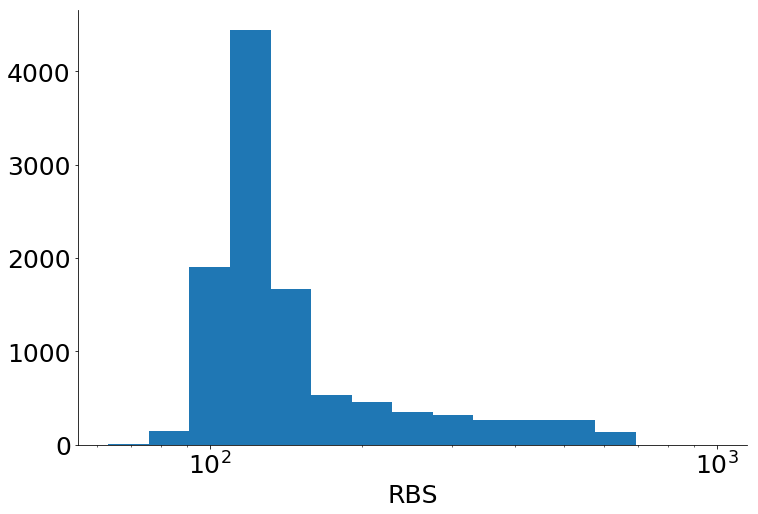

In [53]:
_=plt.hist(irs256.SIGNAL, bins=np.logspace(1.8, 3, 16))
plt.xlabel('RBS')
plt.xscale('log')

In [19]:
dr3rbs = ngalsys(galm, 256)
dr3rbs.prepare_inputs(irs256, selection_function=ranmap)

In [20]:
dr3rbs.digitize_ngalsys(np.logspace(1.8, 3, 16))
dr3rbs.processjack()

/Users/mthecosmologist/Dropbox/github/DESILSS/syslss.py:322: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(std)/(len(self.sysl[i])-1.)


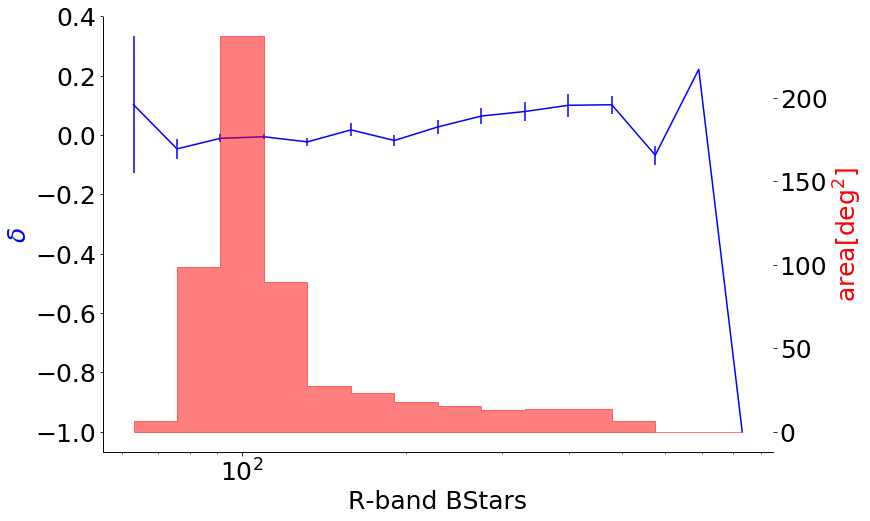

In [21]:
dr3rbs.quickplot('R-band BStars')

In [33]:
from tools import write

In [34]:
write('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/', 'delta_rbs', dr3rbs.output, fmt='npy')

In [54]:
ebvr = ft.read('/Volumes/Mehdi_Passport/work/quicksurvey/ELG/inputs/healSFD_r_256_fullsky.fits')
ebv  = hp.reorder(ebvr/2.75, n2r=True)

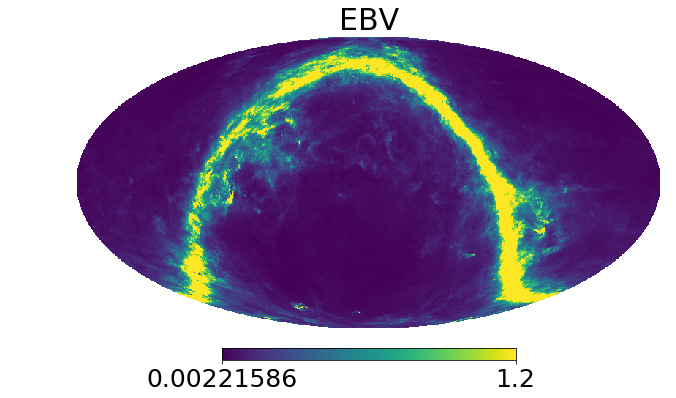

In [55]:
hp.mollview(ebv, max=1.2,title='EBV')

In [56]:
ebv256 = systematic(ebv, ranmap)

Text(0.5,0,'EBV')

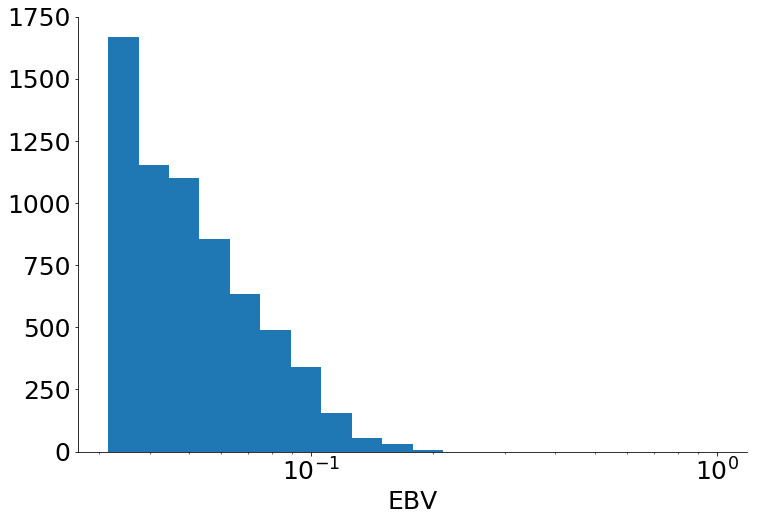

In [57]:
_=plt.hist(ebv256.SIGNAL, bins=np.logspace(-1.5, 0, 21))
plt.xscale('log')
plt.xlabel('EBV')

In [58]:
dr3ebv = ngalsys(galm, 256)
dr3ebv.prepare_inputs(ebv256, selection_function=ranmap)

In [61]:
dr3ebv.digitize_ngalsys(bins=np.logspace(-1.8, 0, 21))
dr3ebv.processjack()

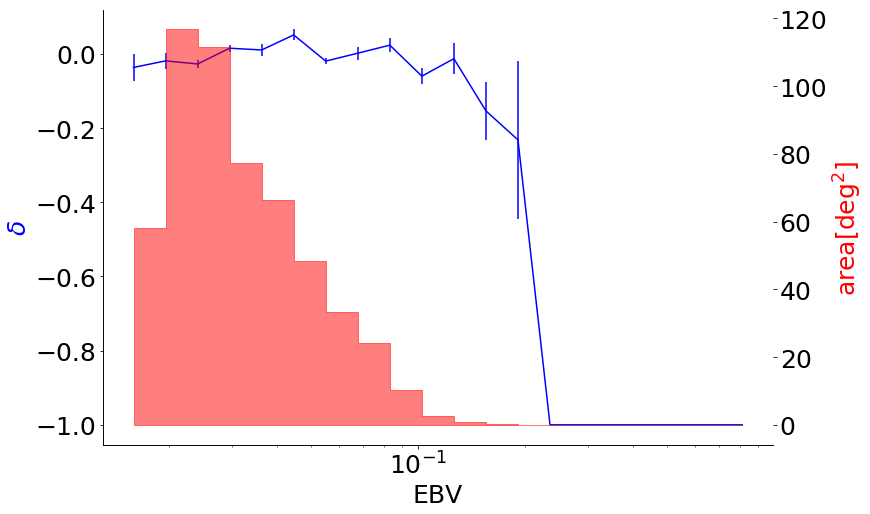

In [62]:
dr3ebv.quickplot('EBV')

In [35]:
write('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/', 'delta_ebv', dr3ebv.output, fmt='npy')

In [36]:
%ls /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/

delta_ebv.npy                       kpks-v05kpkeboss21Y1v5_10_7v05.npy
delta_rbs.npy                       kpks-v05kpkeboss22Y1v5_10_7v05.npy
eboss.tar                           kpks-v05kpkeboss23Y1v5_10_7v05.npy
eboss21.v5_10_7.latest.fits         nofz/
eboss21.v5_10_7.latest.rands.fits   nofz_21and22/
eboss22.v5_10_7.latest.fits         nofz_woSSR/
eboss22.v5_10_7.latest.rands.fits   sector_tsr_ssr_mask_p8_p7.fits
eboss23.v5_10_7.latest.fits         test/
eboss23.v5_10_7.latest.rands.fits   v01_04/
kpks-v05/                           woSSR/


In [37]:
debv = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/delta_ebv.npy').item()
debv.keys()

dict_keys(['delta', 'area', 'delta_err', 'bin_edges', 'attr'])

In [39]:
debv['attr']

{'njack': 20, 'npix2area': 0.0001211963337755561, 'nside': 256}

In [18]:
drbs = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/delta_rbs.npy').item()

(0.7, 1.2)

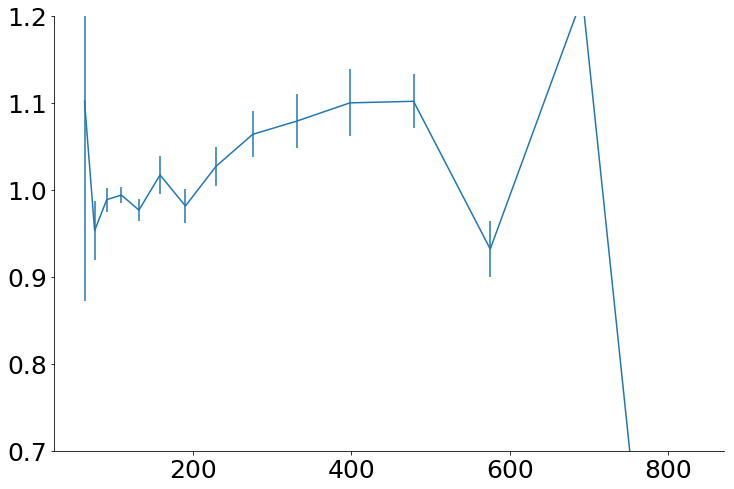

In [166]:
plt.errorbar(drbs['bin_edges'][:-1], drbs['delta'], drbs['delta_err'])
plt.ylim(0.7, 1.2)

In [15]:
from scipy.optimize import minimize

In [54]:
minimize?

In [35]:
def model(theta, x, *args):
    return theta[0] + theta[1] * x

def cf(theta, x, xrange, empty=0.0):
    xmin = xrange[0]
    xmax = xrange[1]
    y    = np.zeros(x.size)
    low = x<= xmin
    high = x>= xmax
    middle = ~(low | high)
    y[low] = model(theta, xmin)
    y[high] = model(theta, xmax)
    y[middle] = model(theta, x[middle])
    y[x==empty] = 0.0
    return y
class sysfit(object):
    def __init__(self,x,y,ye, mask=None):
        if mask is None:
            mask = np.ones(x.size, '?')
        self.org = (x,y,ye)
        self.x  = x[mask]
        self.y  = y[mask]
        self.ye = ye[mask]
        self.mask = mask
        
    def chi2(self, theta,  *args):
        return np.mean( ((model(theta, self.x) - self.y)/(self.ye))**2)
        
    def Minimize(self, theta0):
        self.res = minimize(self.chi2, theta0)
        self.theta = self.res.x
    def plot(self, ylim=(0.7, 1.2)):
        xgrid = np.linspace(self.x.min(), self.x.max())
        xt  = np.linspace(10, 600, 100)
        ax = plt.subplot(111)
        ax.errorbar(*self.org, linestyle='None', marker='o')
        ax.plot(xt, 0.005+cf(self.theta, xt, (self.x.min(), self.x.max())), color='violet')
        ax.plot(xgrid, model(self.theta, xgrid), color='r')
        ax.plot(xgrid, model([1.,0], xgrid), 'k--' )
        ax.text(0.1,0.2, r'$\chi^{}_{}$={:.2f}'.format(2,"{lin}",self.chi2(self.theta)), transform=ax.transAxes, color='r')
        ax.text(0.1,0.1, r'$\chi^{}_{}$={:.2f}'.format(2,"{null}",self.chi2([1.,0])), transform=ax.transAxes, color='k')
        ax.set_ylim(ylim)
        ax.set_xlabel('# R-band BS')
        ax.set_ylabel(r'$N_{gal}/N_{ran, normed}$')
    def makeSF(self, sysmap, empty=0.0):
        return cf(self.theta, sysmap, (self.x.min(), self.x.max()), empty=empty)

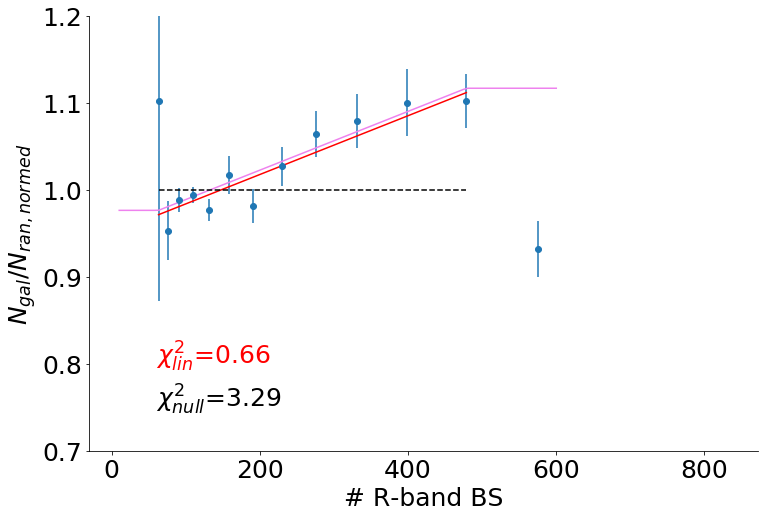

In [36]:
rbsfit = sysfit(drbs['bin_edges'][:-1], drbs['delta'], drbs['delta_err'], mask=(drbs['bin_edges'][:-1]<550))
rbsfit.Minimize([.0,0.0])
rbsfit.plot((0.7, 1.2))

In [185]:
selection_rbs = rbsfit.makeSF(irs)

In [205]:
ft.write('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/selection_rbsfit.fits', selection_rbs)

In [7]:
selection_rbs = ft.read('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/selection_rbsfit.fits')

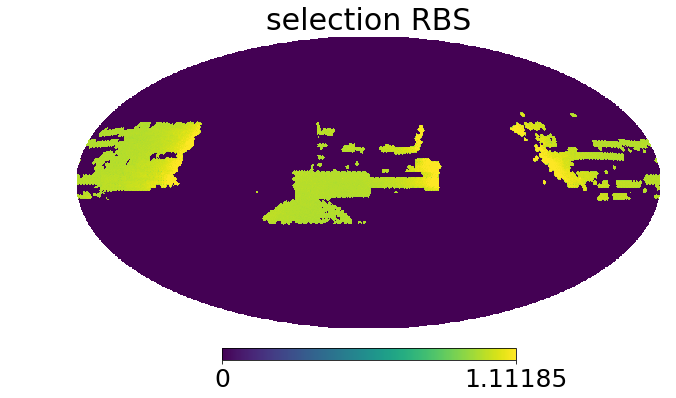

In [19]:
hp.mollview(selection_rbs, title='selection RBS')

In [187]:
dr3rbsfit = ngalsys(galm, 256)
dr3rbsfit.prepare_inputs(irs256, selection_function=ranmap*selection_rbs)

In [188]:
dr3rbsfit.digitize_ngalsys(np.logspace(1.8, 3, 16))
dr3rbsfit.processjack()

/Users/mthecosmologist/Dropbox/github/DESILSS/syslss.py:322: RuntimeWarning: invalid value encountered in double_scalars
  std = np.sqrt(std)/(len(self.sysl[i])-1.)


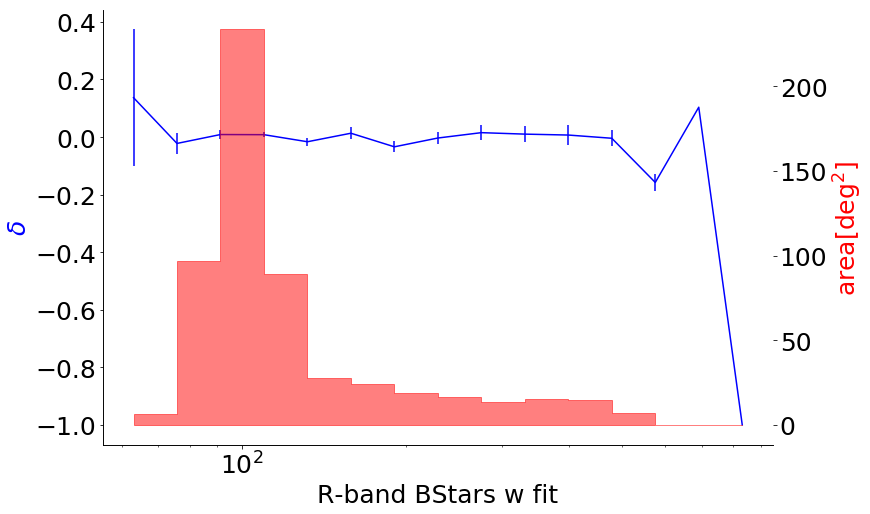

In [189]:
dr3rbsfit.quickplot('R-band BStars w fit')

In [190]:
write('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/', 'delta_rbsfit', dr3rbsfit.output, fmt='npy')

In [23]:
drbs = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/delta_rbs.npy').item()
drbsfit = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/delta_rbsfit.npy').item()

(0.7, 1.2)

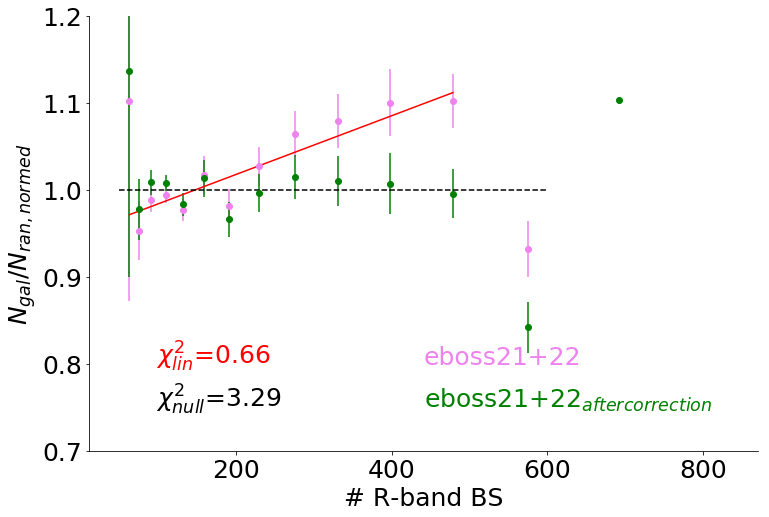

In [63]:
xgrid = np.linspace(rbsfit.x.min(), rbsfit.x.max())
xt  = np.linspace(10, 600, 100)
ax = plt.subplot(111)
# ax.errorbar(*rbsfit.org, linestyle='None', marker='o')
# ax.plot(xt, 0.001+cf(rbsfit.theta, xt, (rbsfit.x.min(), rbsfit.x.max())), color='violet')
ax.plot(xgrid, model(rbsfit.theta, xgrid), color='r')
# ax.plot(xgrid, model([1.,0], xgrid), 'k--' )
ax.text(0.1,0.2, r'$\chi^{}_{}$={:.2f}'.format(2,"{lin}",rbsfit.chi2(rbsfit.theta)), transform=ax.transAxes, color='r')
ax.text(0.1,0.1, r'$\chi^{}_{}$={:.2f}'.format(2,"{null}",rbsfit.chi2([1.,0])), transform=ax.transAxes, color='k')
ax.text(0.5, 0.2, 'eboss21+22', transform=ax.transAxes, color='violet')
ax.text(0.5, 0.1, r'eboss21+22$_{}$'.format("{after correction}"), transform=ax.transAxes, color='green')
ax.set_ylim(0.7,1.2)
ax.set_xlabel('# R-band BS')
ax.set_ylabel(r'$N_{gal}/N_{ran, normed}$')
c = ['violet','green']
for i,drb_i in enumerate([drbs, drbsfit]):
    plt.errorbar(drb_i['bin_edges'][:-1], drb_i['delta'], drb_i['delta_err'], marker='o',linestyle='None', color=c[i])
plt.plot([50., 600.],[1., 1.], 'k--')
plt.ylim(0.7, 1.2)
# plt.xscale('log')

In [8]:
sysweight_rbs = SYSweight(selection_rbs)

In [9]:
path2cats = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
r  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.rands.fits'

#path4nofz = path2cats+'nofz'
#path4nofz = path2cats+'nofz_woSSR'
#path4nofz = path2cats+'nofz_21and22'
analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              path4nofz=path2cats+analysis,
              nofzname='nofz_ebossY1v5_10_7',
              zlim=(0.6,1.1),
              sysweight=sysweight_rbs,
              nmesh=256,
              kpkname='kpk_ebossY1v5_10_7wsysfit',
              path4kpks=path2cats+analysis
             )

In [10]:
path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'\
            +'woSSR/nofz_ebossY1v5_10_7_combinedT.npy'
pkcombsysfit = computePk(['1','2'], **kwargs)
pkcombsysfit.run(save=True, combined=True, path2nofz=path2nofz, **kwargs)
print(pkcombsysfit.log)

/Users/mthecosmologist/anaconda3/envs/nbodykit/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:160: FutureWarning: This init signature is deprecated; see the Cosmology docstring for new signature
  "docstring for new signature"), FutureWarning)


# pipeline to get P(k) for catalogs ['1', '2']
# going to make P(k) while combined:True
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.6 < z < 1.1 with nmesh of 256 
# kpk_ebossY1v5_10_7wsysfit_combinedT is written under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR



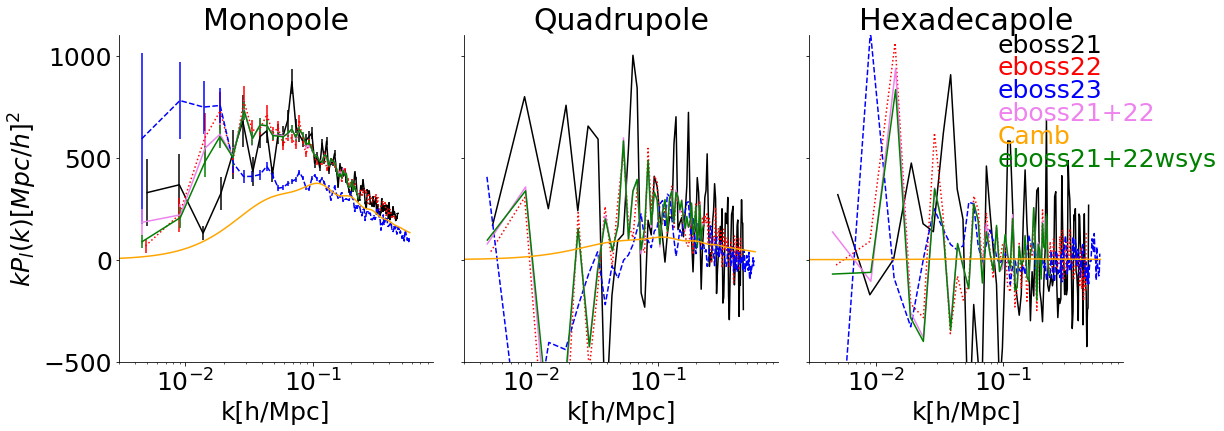

In [11]:
def helper(pkou):
    # break down to k, p0,...
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p4 = pkou['poles_data']['power_4'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    return k, p0, p2, p4, p0e

def addcurve(k, p0, p2, p4, p0e, ax, c, lt, label, i):
    # add curves to plots
    ax[0].errorbar(k, k*p0, k*p0e, color=c, ls=lt)
    ax[1].plot(k, k*p2, color=c, ls=lt)
    ax[2].plot(k, k*p4, color=c, ls=lt)
    ax[2].text(0.6,0.95-i*0.07, label, transform=ax[2].transAxes, color=c)

    
pkall = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7_combinedF.npy').item()
pkcomb = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7_combinedT.npy').item()
pkwsys = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7wsysfit_combinedT.npy').item()
#
f,ax = plt.subplots(ncols=3, sharey=True, figsize=(18,6))
plt.subplots_adjust(wspace=0.1)
#
c  = ['k','r','b']
lt = ['-',':','--']
ttl = ['Monopole','Quadrupole', 'Hexadecapole']
#
for i in range(3):
    k, p0, p2, p4, p0e = helper(pkall['kpk'][i])
    addcurve(k, p0, p2, p4, p0e, ax, c[i], lt[i], 'eboss2'+str(i+1), i)
#
k, p0, p2, p4, p0e = helper(pkcomb['kpk'])
addcurve(k, p0, p2, p4, p0e, ax, 'violet', '-', 'eboss21+22', 3)

k, p0, p2, p4, p0e = helper(pkwsys['kpk'])
addcurve(k, p0, p2, p4, p0e, ax, 'green', '-', 'eboss21+22wsys', 5)
addcurve(kt, plkt[:,0], plkt[:,1], plkt[:,2], 0.0, ax, 'orange', '-', 'Camb', 4)
#
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
for i,a in enumerate(ax):
    a.set_title(ttl[i])
    a.set_xscale('log')
    a.set_xlim(0.003,None)
    a.set_xlabel(r'k[h/Mpc]')
#     a.set_yscale('log')
#     a.set_ylim(10, 1100)
    a.set_ylim(-500, 1100)

(-500, 1100)

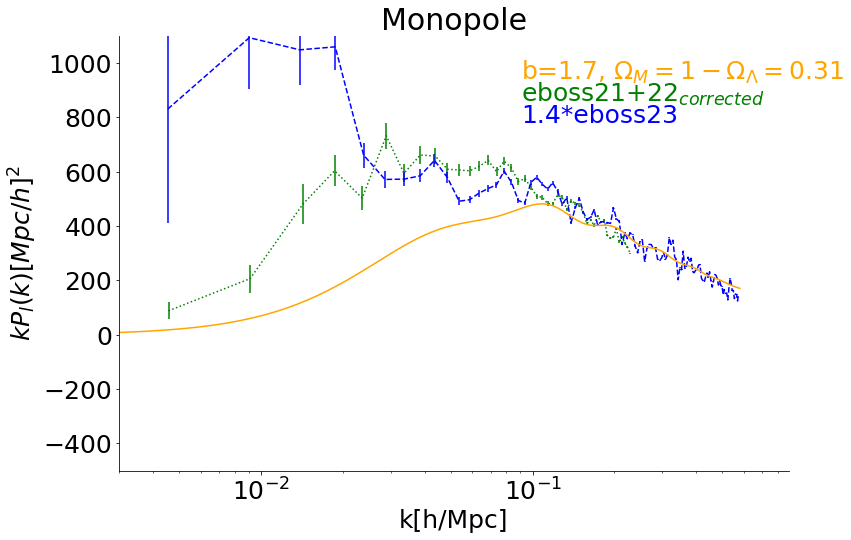

In [47]:
def helper(pkou):
    # break down to k, p0,...
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p4 = pkou['poles_data']['power_4'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    return k, p0, p2, p4, p0e

def addcurve(k, p0, p0e, ax, c, lt, label, i):
    # add curves to plots
    ax.errorbar(k, k*p0, k*p0e, color=c, ls=lt)
    ax.text(0.6,0.9-i*0.05, label, transform=ax.transAxes, color=c)

#
pkall = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7_combinedF.npy').item()
pkcomb = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7wsysfit_combinedT.npy').item()
c  = ['k','r','b']
lt = ['-',':','--']

ax = plt.subplot(111)
i = 1 # eboss21+22
k, p0, _,_, p0e = helper(pkcomb['kpk'])
addcurve(k, p0, p0e, ax, 'green', lt[i], 'eboss21+22$_{corrected}$', i)
i = 2 # ~ eboss23
k, p0, _,_, p0e = helper(pkall['kpk'][i])
addcurve(k, 1.4*p0, p0e, ax, c[i], lt[i], '1.4*eboss2'+str(i+1), i)
i = 0 # Camb
addcurve(kt,  (1.7/1.5)**2*plkt[:,0], 0.0, ax, 'orange', '-', r'b=1.7, $\Omega_{M}=1-\Omega_{\Lambda}=0.31$', i)




ax.set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
ax.set_title(ttl[i])
ax.set_xscale('log')
ax.set_xlim(0.003,None)
ax.set_xlabel(r'k[h/Mpc]')
ax.set_ylim(-500, 1100)

## different zbin <a id="s2.4"></a> 
looking at 0.75 < z < 1.1 (<a href="#top"> top</a>)

In [6]:
path2cats = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
r  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.rands.fits'

analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              path4nofz=path2cats+analysis,
              nofzname='nofz_ebossY1v5_10_7',
              zlim=(0.75,1.1),
              sysweight=None,
              nmesh=256,
              kpkname='kpk_ebossY1v5_10_7zp75',
              path4kpks=path2cats+analysis
             )

In [49]:
path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'\
            +'woSSR/nofz_ebossY1v5_10_7_combinedF.npy'
pksep = computePk(['1','2','3'], **kwargs)
pksep.run(save=True, combined=False, path2nofz=path2nofz, **kwargs)
print(pksep.log)

/Users/mthecosmologist/anaconda3/envs/nbodykit/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:160: FutureWarning: This init signature is deprecated; see the Cosmology docstring for new signature
  "docstring for new signature"), FutureWarning)


# pipeline to get P(k) for catalogs ['1', '2', '3']
# going to make P(k) while combined:False
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.75 < z < 1.1 with nmesh of 256 
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.75 < z < 1.1 with nmesh of 256 
# both galaxy&random sector_tsr > 0.8 sector_ssr > 0.7 
# z_reliable == True   isdupl == False 
# computing p(k) for 0.75 < z < 1.1 with nmesh of 256 
# kpk_ebossY1v5_10_7zp75_combinedF is written under /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/woSSR



In [13]:
%ls

README.md
analysis_ebossY1v5_10_7.ipynb
bash-ebossY1v5_10_7.job
eboss_nn.ipynb
eboss_v5_10_7_NofZ.png
eboss_v5_10_7_Pk.png
ebossv05.py
ebossv05_delta_nstar.py
ebossv05_make_nofz.py
ebossv05_pk_wo_sys.py
kpk_ebossY1v5_10_7_combinedF.npy
make_nofz.py
planck_camb_56106182_matterpower_z0.dat
plots_ebossY1v5_10_7.ipynb
test_arnaud.ipynb


In [7]:
kw,pkw = np.loadtxt('./planck_camb_56106182_matterpower_z0.dat').T

In [8]:
bias = 1.2
z = 0.925
omc = 0.31
beta = (1.0 / bias) * (growthrate(z, omc))
rsdf = rsd(0, beta=beta)
gf2 = (growthfunc(z,0.30)/growthfunc(0,omc))**2

factor=bias**2 * gf2 * rsdf
#
# camb
# theory 
theory_pk = camb_pk(omc=omc)
kt, pkt = theory_pk.get_pk(0) #@ z=0
ktz, pktz = theory_pk.get_pk(z) #@ z=0
# kt, plkt = theory_pk.get_plk(z, bias=bias)

s8 : [ 0.86983054]


s8 : [ 0.53449559]


(-500, 1100)

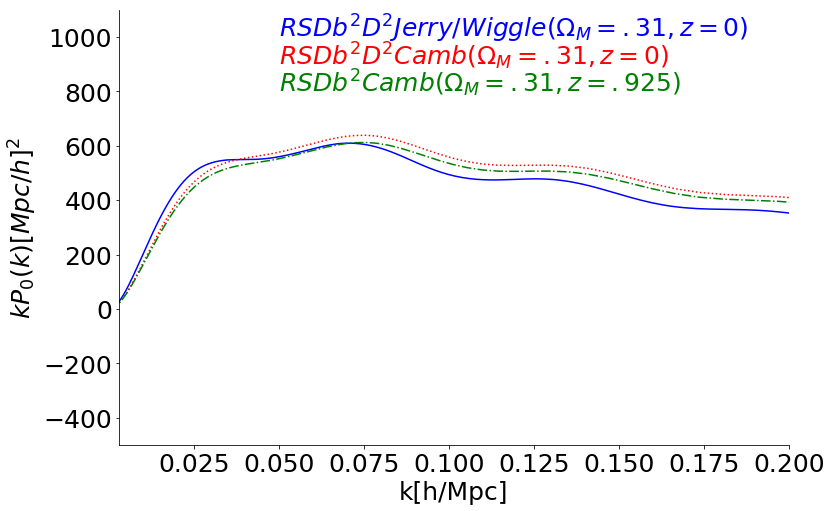

In [9]:
plt.plot(kw, factor*kw*pkw, 'b-',
          kt, factor*kt*pkt, 'r:',
         ktz, factor*ktz*pktz/gf2, 'g-.')

c = ['b', 'r', 'g']
for i,n in enumerate([r'$RSD b^{2}D^{2}Jerry/Wiggle(\Omega_{M}=.31, z=0$)',
                      r'$RSD b^{2}D^{2} Camb (\Omega_{M}=.31, z=0$)',
                      r'$RSD b^{2} Camb(\Omega_{M}=.31,z=.925)$']):
    plt.text(0.05, 1000-i*100, n, color=c[i])
plt.ylabel(r'$kP_{0}(k)[Mpc/h]^{2}$')
plt.xlim(0.003,0.2)
plt.xlabel(r'k[h/Mpc]')
plt.ylim(-500, 1100)

(-500, 1100)

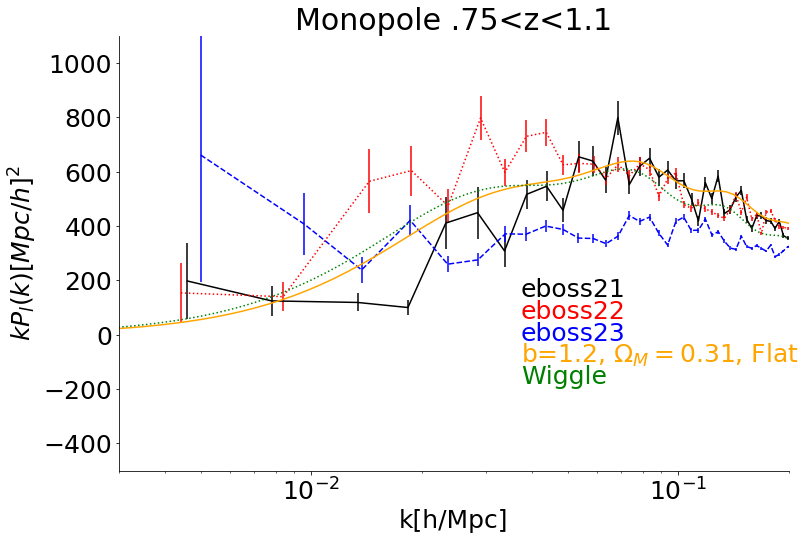

In [10]:
def helper(pkou):
    # break down to k, p0,...
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p4 = pkou['poles_data']['power_4'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    return k, p0, p2, p4, p0e

def addcurve(k, p0, p0e, ax, c, lt, label, i):
    # add curves to plots
    ax.errorbar(k, k*p0, k*p0e, color=c, ls=lt)
    ax.text(0.6,0.4-i*0.05, label, transform=ax.transAxes, color=c)

#
pkall = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7zp75_combinedF.npy').item()

c  = ['k','r','b']
lt = ['-',':','--']

ax = plt.subplot(111)

for i in range(3):
    k, p0, _,_, p0e = helper(pkall['kpk'][i])
    addcurve(k, p0, p0e, ax, c[i], lt[i], 'eboss2'+str(i+1), i)
# Camb
addcurve(kt,  factor*pkt, 0.0, ax, 'orange', '-', r'b=1.2, $\Omega_{M}=0.31$, Flat', 3)
addcurve(kw, factor*pkw, 0.0, ax, 'green', ':', 'Wiggle', 4)

ax.set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
ax.set_title('Monopole .75<z<1.1')
ax.set_xscale('log')
ax.set_xlim(0.003,0.2)
ax.set_xlabel(r'k[h/Mpc]')
ax.set_ylim(-500, 1100)

In [76]:
for i in range(3):
    print('eboss2'+str(i+1))
    print(pkall['kpk'][i]['attrs'], '\n')

eboss21
{'poles': [0, 2, 4], 'dk': 0.005, 'kmin': 0.001, 'use_fkp_weights': True, 'P0_FKP': 6000.0, 'Nmesh': array([256, 256, 256]), 'BoxSize': array([ 1135.,  1712.,   176.]), 'BoxPad': array([ 0.02,  0.02,  0.02]), 'BoxCenter': array([  1.90551044e+03,  -8.38747270e+02,  -3.72857509e-02]), 'mesh.window': 'cic', 'mesh.interlaced': False, 'alpha': 0.015758686336095548, 'data.norm': 0.85419858278735084, 'randoms.norm': 0.85419775449521751, 'shotnoise': 5507.3400514004052, 'randoms.N': 1550682, 'randoms.W': 1458877.9489405155, 'randoms.num_per_cell': 0.036921936136390172, 'data.N': 22990, 'data.W': 22990.0, 'data.num_per_cell': 0.00058177731023012101, 'zbin': (0.75, 1.1)} 

eboss22
{'poles': [0, 2, 4], 'dk': 0.005, 'kmin': 0.001, 'use_fkp_weights': True, 'P0_FKP': 6000.0, 'Nmesh': array([256, 256, 256]), 'BoxSize': array([ 1186.,  1774.,   438.]), 'BoxPad': array([ 0.02,  0.02,  0.02]), 'BoxCenter': array([  1.88126990e+03,   8.69377453e+02,  -2.76032507e-01]), 'mesh.window': 'cic', 'mes

In [35]:
x = np.array([1, 2, 3, 4])
np.cumsum(x)

array([ 1,  3,  6, 10])

(0.75, 1.1)

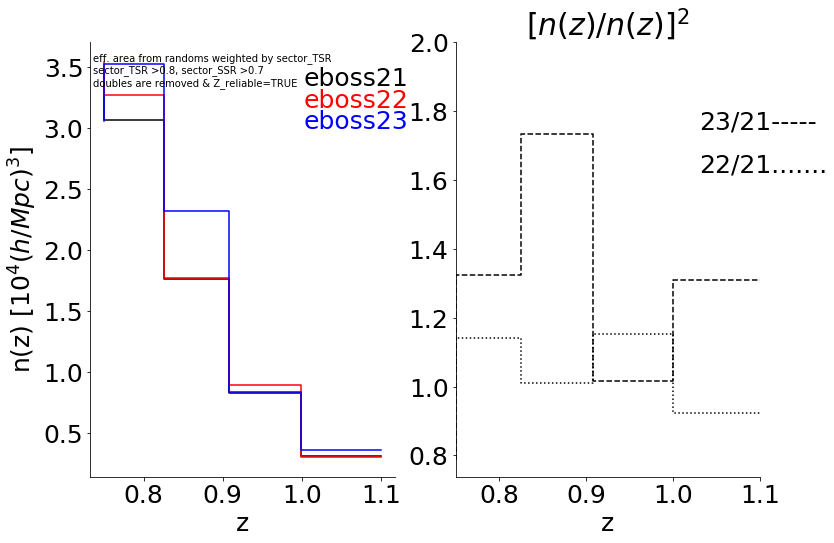

In [70]:
ax = plt.subplot(121)
z=np.logspace(np.log10(0.75), np.log10(1.1), 5)
c  = ['k','r','b']
lt = ['-',':','--']
nzl = []
for i in range(3):
    nz=pkall['kpk'][i]['nz']
    nzl.append(1e4*nz(z))
    ax.step(z, 1e4*nz(z), color=c[i])
    ax.text(0.7, 0.9-0.05*i, 'eboss2'+str(i+1), transform=ax.transAxes, color=c[i])
ax.set_xlabel('z')
ax.set_ylabel(r'n(z) [10$^{4}(h/Mpc)^{3}$]')
ax.text(0.01, 0.9, 'eff. area from randoms weighted by sector_TSR\n'
                                 +'sector_TSR >0.8, sector_SSR >0.7\n'
                                 +'doubles are removed & Z_reliable=TRUE',
                    transform=ax.transAxes, fontsize=10)
ax = plt.subplot(122)
ax.step(z, (nzl[2]/nzl[0])**2, color='k', linestyle='--')
ax.step(z, (nzl[1]/nzl[0])**2, color='k', linestyle=':')
s=['-----','.......']
for i,l in enumerate([3, 2]):
    ax.text(0.8, 0.8-i*0.1, '2'+str(l)+'/21'+s[i], transform=ax.transAxes)
ax.set_title(r'$[n(z)/n(z)]^2$')
ax.set_xlabel('z')
ax.set_ylim(ymax=2.)
ax.set_xlim(.75, 1.1)

In [ ]:
#### path2cats = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
r  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.rands.fits'

analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              path4nofz=path2cats+analysis,
              nofzname='nofz_ebossY1v5_10_7',
              zlim=(0.8,1.1),
              sysweight=None,
              nmesh=256,
              kpkname='kpk_ebossY1v5_10_7zp8',
              path4kpks=path2cats+analysis
             )
path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'\
            +'woSSR/nofz_ebossY1v5_10_7_combinedF.npy'
pksep = computePk(['1','2','3'], **kwargs)
pksep.run(save=True, combined=False, path2nofz=path2nofz, **kwargs)
print(pksep.log)

(-500, 1100)

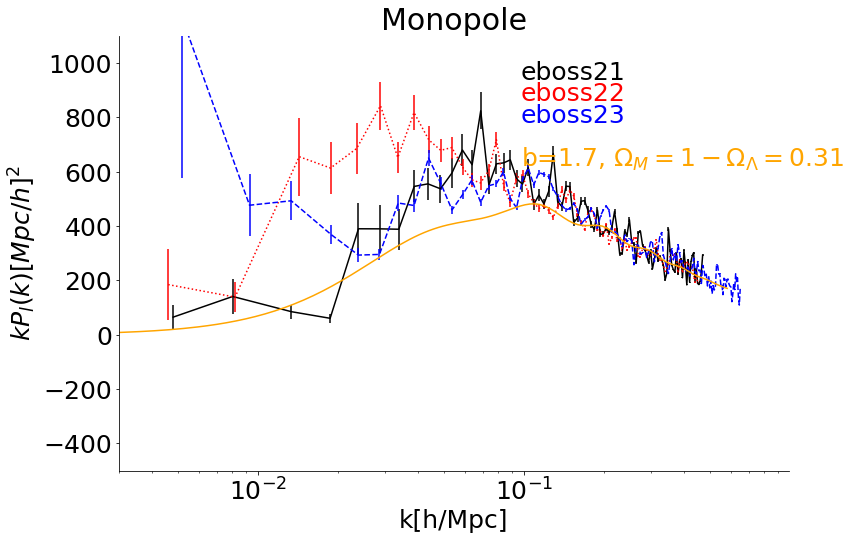

In [55]:
def helper(pkou):
    # break down to k, p0,...
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p4 = pkou['poles_data']['power_4'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    return k, p0, p2, p4, p0e

def addcurve(k, p0, p0e, ax, c, lt, label, i):
    # add curves to plots
    ax.errorbar(k, k*p0, k*p0e, color=c, ls=lt)
    ax.text(0.6,0.9-i*0.05, label, transform=ax.transAxes, color=c)

#
pkall = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
                +'woSSR/kpk_ebossY1v5_10_7zp8_combinedF.npy').item()

c  = ['k','r','b']
lt = ['-',':','--']

ax = plt.subplot(111)

for i in range(3):
    if i==2:
        a = 1.4
    else:
        a = 1.
    k, p0, _,_, p0e = helper(pkall['kpk'][i])
    addcurve(k, a*p0, p0e, ax, c[i], lt[i], 'eboss2'+str(i+1), i)
i = 4 # Camb
addcurve(kt,  (1.7/1.5)**2*plkt[:,0], 0.0, ax, 'orange', '-', r'b=1.7, $\Omega_{M}=1-\Omega_{\Lambda}=0.31$', i)


ax.set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
ax.set_title('Monopole')
ax.set_xscale('log')
ax.set_xlim(0.003,None)
ax.set_xlabel(r'k[h/Mpc]')
ax.set_ylim(-500, 1100)

NN for RBS <a id="s2.5"></a>
<a href="#top">top</a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import numpy as np
import healpy as hp
import sys
sys.path.insert(0,'/Users/mehdi/Dropbox/github/DESILSS')

In [4]:
#
def hpixsum(nside, ra, dec, value=None, nest=False):
    '''
        make a healpix map from ra-dec
        hpixsum(nside, ra, dec, value=None, nest=False)
    '''
    pix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra), nest=nest)
    npix = hp.nside2npix(nside)
    w = np.bincount(pix, weights=value, minlength=npix)
    return w

path2cats = '/Users/mehdi/analyses/eboss/ebossY1v5_10_7/'
g  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.fits'
r  = lambda i: path2cats+'eboss2'+i+'.v5_10_7.latest.rands.fits'

analysis  = 'woSSR'
kwargs = dict(ran_per_sqdeg=10000, 
              cosmo_params={'Om0': 0.31,'H0':69.0,'flat':True},
              tsrmin=0.8,
              ssrmin=0.7,
              galcolnames=['ra','dec','z','z_reliable','sector_tsr',
                      'sector_ssr','weight_systot','isdupl', 'plate_ssr'],
              rancolnames=['ra','dec','sector_ssr','sector_tsr'],
              zbins=np.arange(0.5, 1.2, 0.005),
              path4nofz=path2cats+analysis,
              nofzname='nofz_ebossY1v5_10_7',
              zlim=(0.6,1.1),
              sysweight=None,
              nmesh=256,
              kpkname='kpk_ebossY1v5_10_7zp75',
              path4kpks=path2cats+analysis
             )
ranmap = ft.read('/Users/mehdi/analyses/eboss/ebossY1v5_10_7/sector_tsr_ssr_mask_p8_p7.fits')
irs = ft.read('/Users/mehdi/analyses/eboss/ebossY1v5_10_7/heal_rbs_256.fits')
gal = []
for i in [1, 2]:
    gal.append(ft.read(g(str(i)), lower=True, columns=kwargs['galcolnames']))
gal = np.concatenate(gal)
galmask = (gal['sector_tsr'] > kwargs['tsrmin']) & (gal['sector_ssr'] > kwargs['ssrmin'])
galmask &= (gal['z'] > kwargs['zlim'][0]) & (gal['z'] < kwargs['zlim'][1])
galmask &= (gal['z_reliable']) & (~gal['isdupl'])
gal = gal[galmask]

galmap = hpixsum(256, gal['ra'], gal['dec'])

In [5]:
ran_exp = kwargs['ran_per_sqdeg'] * hp.nside2pixarea(256, degrees=True)
print(ran_exp)

524.5585282569792


In [6]:
fracgood = ranmap / ran_exp

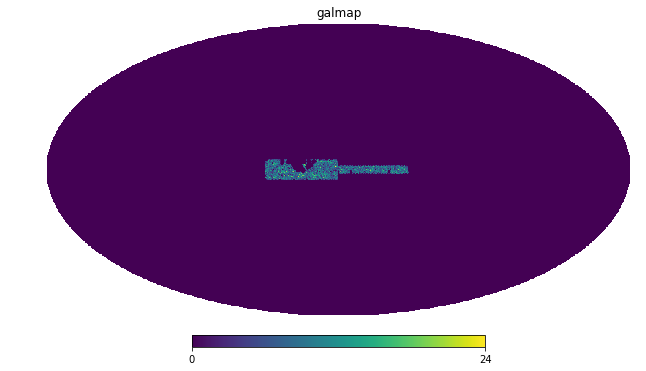

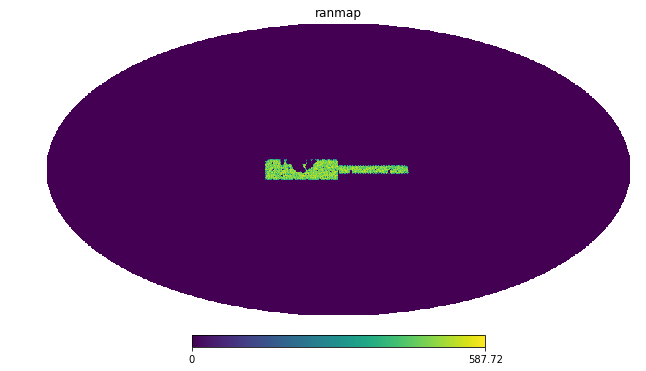

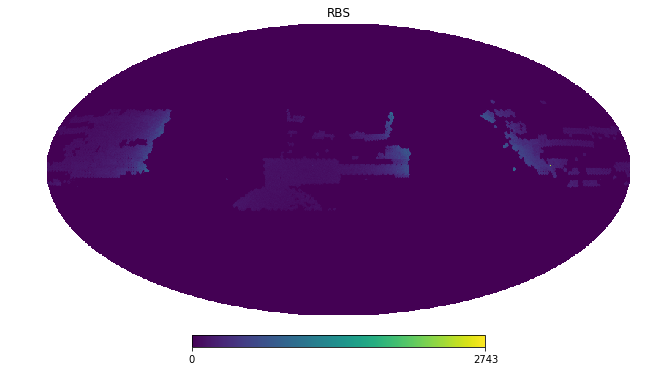

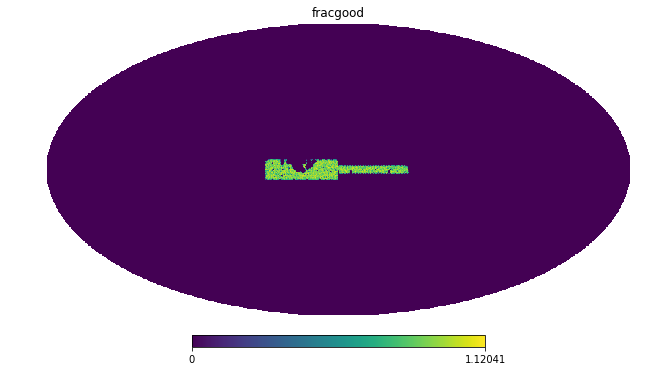

In [7]:
for (n,mp) in [('galmap',galmap), ('ranmap',ranmap), ('RBS',irs), ('fracgood',fracgood)]:
    hp.mollview(mp, title=n)

In [8]:
# select number of galaxies in each pixel as label
arg2 = ranmap > 0
label = galmap[arg2] / fracgood[arg2] # fracgood added on Feb 5
# select healpix indices as hpix
hpix = np.argwhere(arg2).flatten()
# initialize the structured numpy array
outdata = np.zeros(label.size, 
                   dtype=[('hpix','i8'), ('features','f8'), ('label','f8')]
                  )
outdata['hpix'] = hpix
outdata['features'] = irs[arg2]
outdata['label']  = label
outdata[:3]

array([(357891,  86.,  0.        ), (357892, 102.,  0.        ),
       (357893, 124., 34.24681975)],
      dtype=[('hpix', '<i8'), ('features', '<f8'), ('label', '<f8')])

In [9]:
from tools import write
#np.savez('ngal-features-ebv-depth-seeing-airmass-rgz-256-ring-oversample4', outdata)

ModuleNotFoundError: No module named 'sklearn'

In [11]:
#write("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/inputs", "ngal-rbs-eboss21p2", outdata, fmt='npy')
#write("/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/NN/inputs", "ngalfracgood-rbs-eboss21p2", outdata, fmt='npy')
np.save("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/inputs/ngalfracgoodf8-rbs-eboss21p2", outdata)

<a id="s2.6"> ngal and rbs correlation </a>
go to <a href="#top"> top</a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
# tools
import sys
sys.path.append('/Users/mehdi/Dropbox/github/DESILSS')
from syslss import ngalsys

camb is not installed


/Users/mehdi/anaconda3/envs/py3p6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data =np.load("/Users/mehdi/analyses/eboss/ebossY1v5_10_7/NN/inputs/ngalfracgoodf8-rbs-eboss21p2.npy")

In [3]:
data

array([(357891,  86.,  0.        ), (357892, 102.,  0.        ),
       (357893, 124., 34.24681975), ..., (427645, 113., 12.6192872 ),
       (427646, 133., 10.44354803), (427647, 101., 15.94015225)],
      dtype=[('hpix', '<i8'), ('features', '<f8'), ('label', '<f8')])

In [4]:
pearsonr(data['features'], data['label'])

(0.0365360657644514, 0.0001511693131687185)

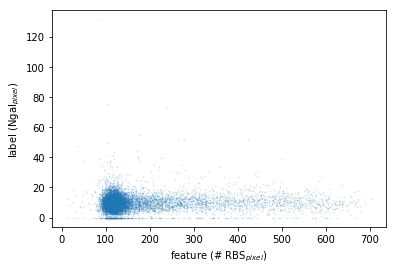

In [5]:
plt.scatter(data['features'], data['label'], 1.0, alpha=0.2, marker='.')
_=plt.xlabel("feature (# RBS$_{pixel}$)")
_=plt.ylabel("label (Ngal$_{pixel}$)")

In [5]:
from scipy.stats import binned_statistic as bs

In [9]:
y,b1,_ = bs(data['features'], data['label'], bins=np.logspace(1.8, 3, 16))
ye,b2,_ = bs(data['features'], data['label'], statistic=np.std,bins=np.logspace(1.8, 3, 16))

In [10]:
np.mean(y[:-1])

10.134255093242558

Text(0,0.5,'N$_{pixel}$/$\\bar{N}$')

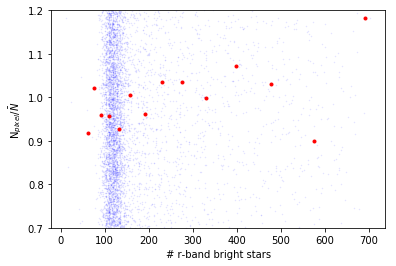

In [11]:
plt.scatter(data['features'], data['label']/10.13, 1.0, alpha=0.1, marker='.', color='b')
plt.errorbar(b1[:-1], y/10.13, 0.0 , ls="None", marker='.', color='r')
plt.ylim(0.7, 1.2)
plt.xlabel("# r-band bright stars")
plt.ylabel(r"N$_{pixel}$/$\bar{N}$")
# plt.xscale('log')
# plt.text(100, 10, "entire dataset")

In [22]:
data['label'].max()

131.1396320642448

In [49]:
# cuts
mask0 = data['label'] > 0
mask1 = data['label'] < 60
mask2 = data['features'] < 400
mask3 = data['features'] > 100
# combination of cuts
mask4 = mask0 & mask1
mask5 = mask0 & mask2
mask6 = mask0 & mask3
mask7 = data['features'] > 200
for i,mask_i in enumerate([mask0, mask1, mask2, 
                           mask3, mask4, mask5, 
                           mask6, mask7]):
    print("mask_{} = {:.4f} "\
          .format(i,pearsonr(data['features'][mask_i],\
                             data['label'][mask_i])[0]))

mask_0 = 0.0502 
mask_1 = 0.0399 
mask_2 = 0.0336 
mask_3 = 0.0408 
mask_4 = 0.0547 
mask_5 = 0.0478 
mask_6 = 0.0585 
mask_7 = -0.0084 


## OLD
Anything after this line is old. 

In [ ]:
# path2nofz = '/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/'
# ax = plt.subplot(111)
# c  = ['k','r','b']
# lt = ['-',':','--']
# for i in range(3):
#     z, nz = np.loadtxt(path2nofz+'nofz_woSSR/nofz_eboss2'+str(i+1)+'.dat').T
#     ax.step(z, 1e4*nz, linestyle=lt[i], color=c[i], alpha=1.0-0.2*i)
#     ax.text(0.7,0.90-i*0.05, 'eboss2'+str(i+1), transform=ax.transAxes, color=c[i])
#     if i ==0:ax.text(0.01, 0.9, 'eff. area from randoms weighted by sector_TSR\n'
#                                  +'sector_TSR >0.8, sector_SSR >0.7\n'
#                                  +'doubles are removed & Z_reliable=TRUE',
#                     transform=ax.transAxes, fontsize=10)
        
# z, nz = np.loadtxt(path2nofz+'nofz_21and22/nofz_eboss21and22.dat').T
# ax.step(z, 1e4*nz, linestyle='-', color='violet', alpha=1.0)
# ax.text(0.7, 0.9-.15, 'eboss21+22', transform=ax.transAxes, color='violet')
# ax.set_xlabel('z')
# ax.set_ylabel(r'n(z) [10$^{4}(h/Mpc)^{3}$]')

In [ ]:
# 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/mthecosmologist/Dropbox/github/DESILSS')

In [ ]:
plt.rc('font', size=25, family='sans-serif')
plt.rc('axes.spines', right=False, top=False)
plt.rc('figure', figsize=(12,8))

In [ ]:
from tools import camb_pk

In [ ]:
kwargs = dict(aa=0, a=2.4, b='hi')
def f(aa=1, b=2, **kwargs1):
    print(aa)
    print(b)
f(**kwargs)

In [ ]:
kwargs

In [ ]:
a =[2, 4]
b = [1, 3]
for i,j in zip(a,b):
    print(i,j)

## Combining 21 and 22
Combining 21 and 22, we get the overl effective area of 465 sq. deg.. This time we did not up weight galaxies by plate_SSR

In [ ]:
%ls /Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/nofz_21and22

In [ ]:
zmid = np.sum([0.6, 1.1])/2.
theory_pk = camb_pk(h=.69, omc=0.31)
kt, plkt = theory_pk.get_plk(zmid, bias=1.5)
kt1, plkt1 = theory_pk.get_plk(zmid, bias=1.)

In [ ]:
# # look at the interpolated N(z)s
# plt.figure()
# c  = ['','k','r','b']
# lt = ['','-',':','--']
# z = np.linspace(0.6, 1.1, 200)
# for i in range(1,4):
#     # reading pks
#     path2pks ='/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpks-v05/'
#     pkou = np.load(path2pks+'kpkeboss2'+str(i)+'Y1v5_10_7v05.npy').item()
#     plt.step(z, 1e4*pkou['nz'](z), label='2%d'%i, color=c[i])
# plt.legend()

In [ ]:
sky_coverage = 0.3
cosmo_params = {'Om0': 0.30,'H0':68.0,'flat':True}
nmesh = 256
tsr_c = 0.5
zlim = (0.6, 1.1)

class cat(object):
    # class to prepare our catalogs for Nbodykit
    def __init__(self, ra, dec, z, w):
        self.RA = ra
        self.DEC = dec
        self.Z = z
        self.Weight = w

In [ ]:
mask = (gal['sector_tsr'] > tsr_c) & (gal['z_reliable'])
galm = gal[mask]
galw = np.ones(galm['ra'].size) # weight
mask = ran['sector_tsr'] > tsr_c # tsr_c = 0.5
ranm = ran[mask]
# sample redshifts for randoms from the bin zlim = (0.6, 1.1)
maskz = (galm['z'] > zlim[0]) & (galm['z'] < zlim[1])
ranz = np.random.choice(galm['z'][maskz], size=ranm['ra'].size) # sampling from galaxies z, w replacement
ranw = ranm['sector_tsr'] * ranm['plate_ssr']


In [ ]:
galaxy = cat(galm['ra'], galm['dec'], galm['z'], galw)
random = cat(ranm['ra'], ranm['dec'], ranz, ranw)

In [ ]:
plt.hist(galaxy.Z, bins=np.linspace(0.6, 1.1, 10), normed=True, alpha=0.5, label='G')
plt.hist(random.Z, bins=np.linspace(0.6, 1.1, 10), normed=True, alpha=0.5, hatch='/', label='R')
plt.legend()
plt.title('eboss21')
_=plt.xlabel('Z')

In [ ]:
plt.rc('font',size=15, family='sans-serif')
f,ax = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
l= ['Galaxy','Random']
c=['b','r']
plt.suptitle('Hexbin plots of GALAXY and RANDOMS from eboss21')
cmapi = [plt.cm.Blues, plt.cm.Reds]
for i,sample in enumerate([galaxy, random]):
    ax[i].hexbin(sample.RA, sample.RA*np.sin(sample.DEC),C=sample.Weight,
           cmap=cmapi[i], reduce_C_function=np.sum,
          gridsize=100)
    ax[i].set_title(l[i], color=c[i])
for a in ax:
    a.set_xlabel('RA')
ax[0].set_ylabel('RAxSin(DEC)')

In [ ]:
plt.rc('axes.spines', right=False, top=False)
plt.rc('font',size=15, family='sans-serif')
f,ax = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
plt.subplots_adjust(wspace=0.1)
for i in range(1,4):
    pkou = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpkeboss2'+str(i)+'Y1v5_10_7.npy').item()
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    ax[i-1].set_title('eboss2'+str(i))
    ax[i-1].errorbar(k, k*p0, k*p0e, color='b')
    ax[i-1].plot(k, k*p2, color='r', ls='--')
    if i==3:
        ax[i-1].text(0.6,0.9, 'Monopole', transform=ax[i-1].transAxes, color='b')
        ax[i-1].text(0.6,0.85, 'Quadrupole', transform=ax[i-1].transAxes, color='r')        
    
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{3}$')
for a in ax:
    a.set_xlabel(r'k[h/Mpc]')
    a.ticklabel_format( style='sci', axis='y',scilimits=(0,0))

In [ ]:
plt.rc('axes.spines', right=False, top=False)
plt.rc('font',size=15, family='sans-serif')
f,ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
plt.subplots_adjust(wspace=0.1)
c = ['k','b','r','g']

for i in range(1,4):
    pkou = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpkeboss2'+str(i)+'Y1v5_10_7.npy').item()
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    ax[0].errorbar(k, k*p0, k*p0e, color=c[i])
    ax[1].plot(k, k*p2, color=c[i], ls='--')
    ax[1].text(0.6,0.95-i*0.05, 'eboss2'+str(i), transform=ax[1].transAxes, color=c[i])

ax[0].set_title('Monopole')
ax[1].set_title('Quadrupole')
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{3}$')
for a in ax:
    a.set_xlabel(r'k[h/Mpc]')
    a.ticklabel_format( style='sci', axis='y',scilimits=(0,0))

In [ ]:
plt.rc('axes.spines', right=False, top=False)
plt.rc('font',size=15, family='sans-serif')
f,ax = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
plt.subplots_adjust(wspace=0.1)
c = ['k','b','r','g']

for i in range(1,4):
    pkou = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpkeboss2'+str(i)+'Y1v5_10_7v02.npy').item()
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    ax[0].errorbar(k, k*p0, k*p0e, color=c[i])
    ax[1].plot(k, k*p2, color=c[i], ls='--')
    ax[1].text(0.6,0.95-i*0.05, 'eboss2'+str(i), transform=ax[1].transAxes, color=c[i])

ax[0].set_title('Monopole')
ax[1].set_title('Quadrupole')
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
for a in ax:
    a.set_xlim(xmax=0.4)
    a.set_xlabel(r'k[h/Mpc]')
    a.set_ylim(ymin=-50000)
    a.ticklabel_format( style='sci', axis='y',scilimits=(0,0))

### catch the bug in v02 and v01 -- fsky is not 0.3
In v03, we use the same fsky (.006) for all chunks, whereas (ran!=0.0).sum/ran.size would give different values (?)

In [ ]:
plt.rc('axes.spines', right=False, top=False)
plt.rc('font',size=15, family='sans-serif')
f,ax = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
plt.subplots_adjust(wspace=0.1)
c = ['k','b','r','g']

for i in range(1,4):
    pkou = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpkeboss2'+str(i)+'Y1v5_10_7v03.npy').item()
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    ax[0].errorbar(k, k*p0, k*p0e, color=c[i])
    ax[1].plot(k, k*p2, color=c[i], ls='--')
    ax[1].text(0.6,0.95-i*0.05, 'eboss2'+str(i), transform=ax[1].transAxes, color=c[i])

ax[0].set_title('Monopole')
ax[1].set_title('Quadrupole')
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
for a in ax:
    a.set_xscale('log')
    a.set_xlim(xmax=0.4)
    a.set_xlabel(r'k[h/Mpc]')
    a.set_yscale('log')
#     a.set_ylim(-600, 1100)
#     a.ticklabel_format( style='sci', axis='y',scilimits=(1,10))
    a.grid()

### fsky is evaluated for each chunk based on their randoms

In [ ]:
plt.rc('axes.spines', right=False, top=False)
plt.rc('font',size=15, family='sans-serif')
f,ax = plt.subplots(ncols=2, sharey=True, figsize=(12,5))
plt.subplots_adjust(wspace=0.1)
c = ['k','b','r','g']

for i in range(1,4):
    pkou = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpkeboss2'+str(i)+'Y1v5_10_7v04.npy').item()
    k = pkou['poles_data']['k']
    p0 = pkou['poles_data']['power_0'].real - pkou['attrs']['shotnoise']
    p2 = pkou['poles_data']['power_2'].real
    p0e = p0 / np.sqrt(0.5*pkou['poles_data']['modes'])
    ax[0].errorbar(k, k*p0, k*p0e, color=c[i])
    ax[1].plot(k, k*p2, color=c[i], ls='--')
    ax[1].text(0.6,0.95-i*0.05, 'eboss2'+str(i), transform=ax[1].transAxes, color=c[i])

ax[0].set_title('Monopole')
ax[1].set_title('Quadrupole')
ax[0].set_ylabel(r'$kP_{l}(k)[Mpc/h]^{2}$')
for a in ax:
#     a.set_xscale('log')
    a.set_xlim(xmax=0.4)
    a.set_xlabel(r'k[h/Mpc]')
#     a.set_yscale('log')
    a.set_ylim(-500, 1100)
#     a.ticklabel_format( style='sci', axis='y',scilimits=(1,10))
    a.grid()

In [ ]:
plt.rc('axes.spines', right=False, top=False)
plt.rc('font',size=15, family='sans-serif')
plt.figure()
c = ['k','b','r','g']
z = np.linspace(0.6, 1.1, 20)
for i in range(1,4):
    pkou = np.load('/Users/mthecosmologist/analyses/eboss/ebossY1v5_10_7/kpkeboss2'+str(i)+'Y1v5_10_7v05.npy').item()
    plt.plot(z, 1e4*pkou['nz'](z), label='2%d'%i)
plt.legend()

In [ ]:
y1 = np.random.normal(0, 1, size=1000)
w1 = np.ones(y1.shape)
w1[y1 >0.1] = 0.0
bins= np.linspace(-3, 3, 10)
y2 = np.random.choice(y1, size=500)
y3 = np.random.choice(y1, size=500, p=w1/w1.sum())
plt.hist(y1, normed=True, hatch='/', alpha=0.2, bins=bins)
plt.hist(y1, weights=w1, normed=True, hatch='.', alpha=0.2, bins=bins)
plt.hist(y2, normed=True, alpha=0.2, bins=bins)
plt.hist(y3, normed=True, alpha=0.2, bins=bins, hatch='+')


In [ ]:
b = None
if not b:
    print('hi')